In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv("Data/merged_data.csv", index_col = 0)
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,Article_title,Stock_symbol,Url,1d_open,1d_close,3d_close,Unnamed: 0,Predicted_Price_Diff,3d_change,3d_direction,arima_3d_direction
0,2020-06-10,Tech Stocks And FAANGS Strong Again To Start D...,AAPL,https://www.benzinga.com/government/20/06/1622...,349.309998,335.899994,342.989990,59.0,1.373906,-1.809283,-1,1
1,2020-06-10,10 Biggest Price Target Changes For Wednesday,AAPL,https://www.benzinga.com/analyst-ratings/price...,349.309998,335.899994,342.989990,59.0,1.373906,-1.809283,-1,1
2,2020-06-09,"Benzinga Pro's Top 5 Stocks To Watch For Wed.,...",AAPL,https://www.benzinga.com/short-sellers/20/06/1...,347.899994,352.839996,338.799988,58.0,-1.947308,-2.615696,-1,-1
3,2020-06-09,"Deutsche Bank Maintains Buy on Apple, Raises P...",AAPL,https://www.benzinga.com/news/20/06/16219873/d...,347.899994,352.839996,338.799988,58.0,-1.947308,-2.615696,-1,-1
4,2020-06-09,Apple To Let Users Trade In Their Mac Computer...,AAPL,https://www.benzinga.com/news/20/06/16218697/a...,347.899994,352.839996,338.799988,58.0,-1.947308,-2.615696,-1,-1


In [3]:
import gensim
from gensim.models import Word2Vec
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download stopwords if needed
import nltk
nltk.download('stopwords')
nltk.download('punkt')

# Load English stopwords
stop_words = set(stopwords.words('english'))

# Preprocess text: remove stopwords and tokenize
def preprocess(text):
    words = word_tokenize(text.lower())  # Tokenize and convert to lowercase
    return [word for word in words if word.isalpha() and word not in stop_words]

# Prepare data for Word2Vec model
sentences = df['Article_title'].dropna().apply(preprocess).tolist()

# Train a Word2Vec model on the preprocessed sentences
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Function to compute the average word2vec for a sentence
def sentence_to_vector(sentence, model):
    words = preprocess(sentence)
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)  # Return zero vector if no valid words
    return np.mean(word_vectors, axis=0)

# Add 'word2vec' column to merged_df
df['word2vec'] = df['Article_title'].apply(lambda x: sentence_to_vector(str(x), word2vec_model) if pd.notnull(x) else np.zeros(word2vec_model.vector_size))

# Check the new column
print(df[['Article_title', 'word2vec']].head())


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jerry\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jerry\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


                                       Article_title  \
0  Tech Stocks And FAANGS Strong Again To Start D...   
1      10 Biggest Price Target Changes For Wednesday   
2  Benzinga Pro's Top 5 Stocks To Watch For Wed.,...   
3  Deutsche Bank Maintains Buy on Apple, Raises P...   
4  Apple To Let Users Trade In Their Mac Computer...   

                                            word2vec  
0  [0.044554148, 0.047870234, -0.07244691, 0.0356...  
1  [0.45047203, 0.4061913, 0.14586128, 0.37401068...  
2  [-0.030724855, 0.035128064, 0.11400303, 0.2415...  
3  [0.44818988, 0.20165133, -0.17587534, 0.441852...  
4  [0.0712902, 0.024643691, -0.10670274, 0.102350...  


In [4]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm

# Check if GPU is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load a pre-trained BERT model and tokenizer, and move the model to GPU if available
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name).to(device)

# Function to generate BERT embeddings for a sentence using GPU if available
def sentence_to_bert_embedding(sentence, model, tokenizer, device):
    inputs = tokenizer(sentence, return_tensors='pt', truncation=True, padding=True, max_length=128).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    # Average the embeddings of all tokens to create a sentence embedding
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
    return embeddings

# Apply the BERT embedding function to the Article_title column with progress bar
tqdm.pandas(desc="Generating BERT Embeddings")
df['bert'] = df['Article_title'].progress_apply(
    lambda x: sentence_to_bert_embedding(str(x), bert_model, tokenizer, device) if pd.notnull(x) else np.zeros(768)
)

# Check the new column
print(df[['Article_title', 'bert']].head())


Using device: cuda


KeyboardInterrupt: 

In [7]:
df.head()

,Date,Article_title,Stock_symbol,Url,1d_open,1d_close,3d_close,Unnamed: 0,Predicted_Price_Diff,3d_change,3d_direction,arima_3d_direction
0,2020-06-10,Tech Stocks And FAANGS Strong Again To Start D...,AAPL,https://www.benzinga.com/government/20/06/1622...,349.309998,335.899994,342.989990,59.0,1.373906,-1.809283,-1,1
1,2020-06-10,10 Biggest Price Target Changes For Wednesday,AAPL,https://www.benzinga.com/analyst-ratings/price...,349.309998,335.899994,342.989990,59.0,1.373906,-1.809283,-1,1
2,2020-06-09,"Benzinga Pro's Top 5 Stocks To Watch For Wed.,...",AAPL,https://www.benzinga.com/short-sellers/20/06/1...,347.899994,352.839996,338.799988,58.0,-1.947308,-2.615696,-1,-1
3,2020-06-09,"Deutsche Bank Maintains Buy on Apple, Raises P...",AAPL,https://www.benzinga.com/news/20/06/16219873/d...,347.899994,352.839996,338.799988,58.0,-1.947308,-2.615696,-1,-1
4,2020-06-09,Apple To Let Users Trade In Their Mac Computer...,AAPL,https://www.benzinga.com/news/20/06/16218697/a...,347.899994,352.839996,338.799988,58.0,-1.947308,-2.615696,-1,-1


In [8]:
print(f'Word2Vec Embedding Size is 100, and Bert is {len(df["bert"][0])}')

KeyError: 'bert'

In [ ]:
# df.to_pickle("Data/news_embeddings.pkl")

In [3]:
df = pd.read_pickle("Data/news_embeddings.pkl")

In [4]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = df[df['3d_direction'] == 1]
df_minority = df[df['3d_direction'] == -1]

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                   replace=False,    # Sample without replacement
                                   n_samples=len(df_minority),  
                                   random_state=42)

# Combine downsampled majority class with minority class
df_balanced = pd.concat([df_majority_downsampled, df_minority])

# Check new class distribution
print(df_balanced['3d_direction'].value_counts())


3d_direction
 1    7795
-1    7795
Name: count, dtype: int64


In [5]:
from sklearn.model_selection import train_test_split
# Prepare input features and target variable
X_word2vec = np.stack(df_balanced['word2vec'].values)
X_bert = np.stack(df_balanced['bert'].values)
y = df_balanced['3d_direction'].values

# Split the data into training and testing sets
X_train_w2v, X_test_w2v, y_train, y_test = train_test_split(X_word2vec, y, test_size=0.2, random_state=42, stratify=y)
X_train_bert, X_test_bert, _, _ = train_test_split(X_bert, y, test_size=0.2, random_state=42, stratify=y)

In [6]:
from sklearn.metrics import (
        accuracy_score, f1_score, precision_score, recall_score, 
        roc_auc_score, classification_report, confusion_matrix
    )
import pandas as pd
import matplotlib.pyplot as plt

def visualize_performance(y_test, y_pred_w2v, y_pred_bert):
    
    # Additional metrics
    metrics = {
        "Model": ["Word2Vec", "BERT"],
        "Accuracy": [accuracy_score(y_test, y_pred_w2v), accuracy_score(y_test, y_pred_bert)],
        "F1 Score": [f1_score(y_test, y_pred_w2v), f1_score(y_test, y_pred_bert)],
        "Precision": [precision_score(y_test, y_pred_w2v), precision_score(y_test, y_pred_bert)],
        "Recall": [recall_score(y_test, y_pred_w2v), recall_score(y_test, y_pred_bert)],
        "ROC AUC": [roc_auc_score(y_test, y_pred_w2v), roc_auc_score(y_test, y_pred_bert)]
    }

    metrics_df = pd.DataFrame(metrics)
    print(metrics_df)
    
    # Plot confusion matrices
    fig, axes = plt.subplots(1, 3, figsize=(10, 3))

    # Confusion matrix for Word2Vec model
    sns.heatmap(confusion_matrix(y_test, y_pred_w2v), annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title('Word2Vec Model Confusion Matrix')
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('True Label')

    # Confusion matrix for BERT model
    sns.heatmap(confusion_matrix(y_test, y_pred_bert), annot=True, fmt='d', cmap='Greens', ax=axes[1])
    axes[1].set_title('BERT Model Confusion Matrix')
    axes[1].set_xlabel('Predicted Label')
    axes[1].set_ylabel('True Label')
    
    metrics_melted = metrics_df.melt(id_vars=['Model'], 
                                 value_vars=['Accuracy', 'F1 Score', 'Precision', 'Recall', 'ROC AUC'],
                                 var_name='Metric', 
                                 value_name='Score')
    
    sns.barplot(data=metrics_melted, x='Model', y='Score', hue='Metric', ax=axes[2], palette='Greens')
    axes[2].set_title('Model Performance Metrics')
    axes[2].set_xlabel('Model')
    axes[2].set_ylabel('Score')
    axes[2].set_ylim(0, 1)
    axes[2].axhline(0.5, color='red', linestyle='--', label='Baseline (0.5)')
    axes[2].legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

      Model  Accuracy  F1 Score  Precision    Recall   ROC AUC
0  Word2Vec  0.503207  0.550884   0.502646  0.609365  0.503207
1      BERT  0.511225  0.517416   0.510944  0.524054  0.511225


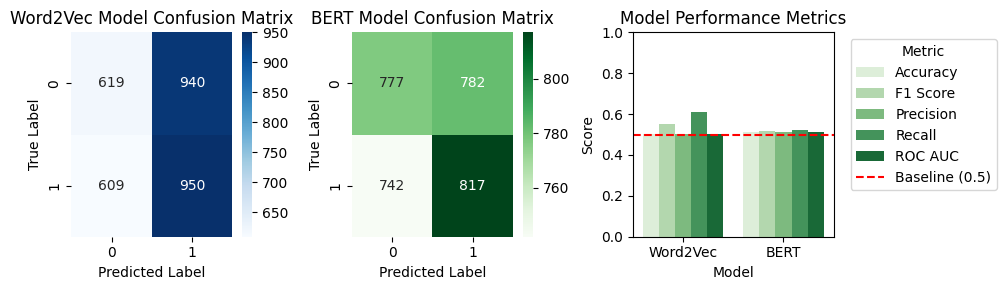

In [111]:
from sklearn.linear_model import LogisticRegression

# Initialize logistic regression models
model_word2vec = LogisticRegression(max_iter=1000, random_state=42)
model_bert = LogisticRegression(max_iter=1000, random_state=42)

# Train the models
model_word2vec.fit(X_train_w2v, y_train)
model_bert.fit(X_train_bert, y_train)

# Make predictions
y_pred_w2v = model_word2vec.predict(X_test_w2v)
y_pred_bert = model_bert.predict(X_test_bert)

visualize_performance(y_test, y_pred_w2v, y_pred_bert)

      Model  Accuracy  F1 Score  Precision    Recall   ROC AUC
0  Word2Vec  0.522130  0.522130   0.522130  0.522130  0.522130
1      BERT  0.539128  0.537794   0.539355  0.536241  0.539128


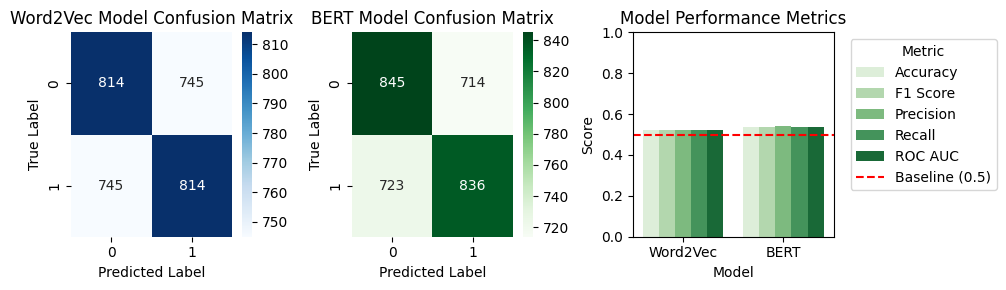

In [112]:
from lightgbm import LGBMClassifier

# Initialize LightGBM models
model_word2vec = LGBMClassifier(random_state=42,  learning_rate=0.2, n_estimators= 500, num_leaves= 100)
model_bert = LGBMClassifier(random_state=42,  learning_rate=0.1, n_estimators= 800, num_leaves= 100)

# Train the models
model_word2vec.fit(X_train_w2v, y_train)
model_bert.fit(X_train_bert, y_train)

# Make predictions
y_pred_w2v = model_word2vec.predict(X_test_w2v)
y_pred_bert = model_bert.predict(X_test_bert)

visualize_performance(y_test, y_pred_w2v, y_pred_bert)

### Some Grid Search (Already Run)

In [8]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'num_leaves': [30, 50, 100],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 300, 500],
    'device': ['gpu']  # Enable GPU support
}

grid = GridSearchCV(
    LGBMClassifier(random_state=42, device='gpu'), 
    param_grid, 
    scoring='f1', 
    cv=5, 
    verbose=1, 
    n_jobs=1  # Use single process to avoid pickling issues
)

grid.fit(X_train_bert, y_train)

print(f"Best Parameters: {grid.best_params_}")
print(f"Best F1 Score: {grid.best_score_}")


Fitting 5 folds for each of 18 candidates, totalling 90 fits
[LightGBM] [Info] Number of positive: 4989, number of negative: 4988
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 9977, number of used features: 768
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4090, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 768 dense feature groups (7.31 MB) transferred to GPU in 0.007431 secs. 0 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500050 -> initscore=0.000200
[LightGBM] [Info] Start training from score 0.000200
[LightGBM] [Info] Number of positive: 4988, number of negative: 4989
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 9

[LightGBM] [Info] Number of positive: 4989, number of negative: 4989
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 9978, number of used features: 768
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4090, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 768 dense feature groups (7.31 MB) transferred to GPU in 0.007898 secs. 0 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 4989, number of negative: 4989
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 9978, number of used features: 768
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4090, Vendor: NVIDIA Corp

[LightGBM] [Info] Number of positive: 4989, number of negative: 4989
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 9978, number of used features: 768
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4090, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 768 dense feature groups (7.31 MB) transferred to GPU in 0.007695 secs. 0 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 4989, number of negative: 4988
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 9977, number of used features: 768
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4090, Vendor: NVIDIA Corp

[LightGBM] [Info] Number of positive: 4988, number of negative: 4989
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 9977, number of used features: 768
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4090, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 768 dense feature groups (7.31 MB) transferred to GPU in 0.008395 secs. 0 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499950 -> initscore=-0.000200
[LightGBM] [Info] Start training from score -0.000200
[LightGBM] [Info] Number of positive: 4989, number of negative: 4989
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 9978, number of used features: 768
[LightGBM] [Info] Using G

[LightGBM] [Info] Number of positive: 4989, number of negative: 4989
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 9978, number of used features: 768
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4090, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 768 dense feature groups (7.31 MB) transferred to GPU in 0.007803 secs. 0 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 4989, number of negative: 4989
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 9978, number of used features: 768
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4090, Vendor: NVIDIA Corp

[LightGBM] [Info] Number of positive: 4989, number of negative: 4988
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 9977, number of used features: 768
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4090, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 768 dense feature groups (7.31 MB) transferred to GPU in 0.007972 secs. 0 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500050 -> initscore=0.000200
[LightGBM] [Info] Start training from score 0.000200
[LightGBM] [Info] Number of positive: 4988, number of negative: 4989
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 9977, number of used features: 768
[LightGBM] [Info] Using GPU

[LightGBM] [Info] Number of positive: 4989, number of negative: 4989
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 9978, number of used features: 768
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4090, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 768 dense feature groups (7.31 MB) transferred to GPU in 0.008055 secs. 0 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 4989, number of negative: 4989
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 9978, number of used features: 768
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4090, Vendor: NVIDIA Corp

[LightGBM] [Info] Number of positive: 4989, number of negative: 4989
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 9978, number of used features: 768
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4090, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 768 dense feature groups (7.31 MB) transferred to GPU in 0.007564 secs. 0 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 4989, number of negative: 4988
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 9977, number of used features: 768
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4090, Vendor: NVIDIA Corp

Best Parameters: {'device': 'gpu', 'learning_rate': 0.1, 'n_estimators': 500, 'num_leaves': 100}
Best F1 Score: 0.6625765289312965

      Model  Accuracy  F1 Score  Precision    Recall  ROC AUC
0  Word2Vec  0.614387  0.641901   0.636564  0.647329  0.61199
1      BERT  0.614387  0.641901   0.636564  0.647329  0.61199


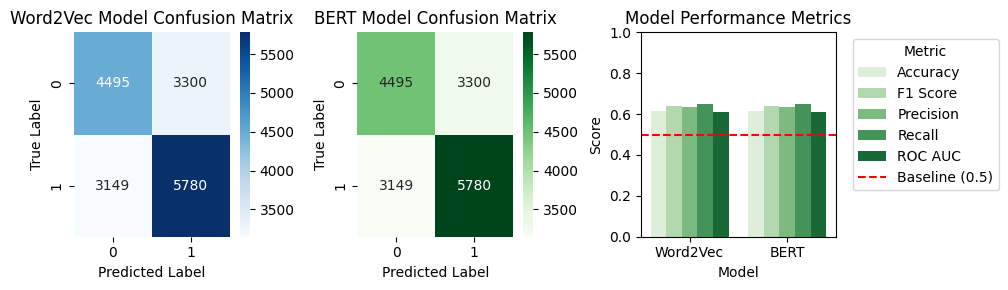

In [11]:
df
import seaborn as sns
visualize_performance(df["3d_direction"], df["arima_3d_direction"], df["arima_3d_direction"])

In [19]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 500],
    'device': ['gpu']  # Enable GPU support
}

grid = GridSearchCV(
    LGBMClassifier(random_state=42, device='gpu'), 
    param_grid, 
    scoring='f1', 
    cv=5, 
    verbose=0, 
    n_jobs=1  # Use single process to avoid pickling issues
)

grid.fit(X_train_w2v, y_train)

print(f"Best Parameters: {grid.best_params_}")
print(f"Best F1 Score: {grid.best_score_}")


ImportError: cannot import name 'LGBMClassifier' from 'lightgbm' (unknown location)

Best Parameters: {'device': 'gpu', 'learning_rate': 0.2, 'n_estimators': 500, 'num_leaves': 100}

In [18]:
import sys
print(sys.executable)


C:\Users\Jerry\anaconda3\envs\env1-gpu\python.exe
